In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import glob
import warnings
warnings.filterwarnings('ignore')

In [4]:
files = glob.glob("data/d*.csv")

df_list = []
for i in files:
    csv = pd.read_csv(i)
    df_list.append(csv)

In [5]:
def heatmap_aic(data, color):
    fig, ax = plt.subplots()
    ax = sns.heatmap(data, annot=True, fmt=".3f",linewidth=.5 , cmap=color)
    ax.set(xlabel="AR", ylabel="MA")
    ax.xaxis.set_label_position('top') 
    ax.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, left=False, labeltop=True, rotation=0)
    ax.collections[0].colorbar.ax.invert_yaxis()
    plt.show()

for i in range(2): 
    heatmap_aic(aic_list[p], "Reds_r")


NameError: name 'aic_list' is not defined

In [6]:
def arma(data, n):
    aic = np.zeros((n,n))
    coef = np.zeros((n,n))
    homo = np.zeros((n,n))
    auto = np.zeros((n,n))
    norm = np.zeros((n,n))

    for q in range(n):
        for p in range(n):
            # Estimation du modèle ARMA(p,q)
            result = ARIMA(data, order=(p,0,q), trend='n').fit()
            # Critère Akaike 
            aic[q][p] = result.aic/data.size
            
            # Siginificativité des paramètres
            if (result.pvalues <= 0.05).all():
                coef[q][p] = 1
            else:
                coef[q][p] = 0

            # Test autocorrélation des résidus (Ljung-Box)
            if (result.test_serial_correlation('ljungbox',lags=20, df_adjust=True)[0][1][p+q:]> 0.05).all():
                auto[q][p] = 1
            else:
                auto[q][p] = 0

            # Homoscédasticité des résidus (ARCH)
            if sm.stats.diagnostic.het_arch(result.resid, nlags=8)[2] > 0.05:
                homo[q][p] = 1
            else:
                homo[q][p] = 0
        
            # Normalité des résidus (JB)
            if result.test_normality('jarquebera')[0][1] > 0.05:
                norm[p][q] = 1
            else:
                norm[q][p] = 0
    
    aic = pd.DataFrame(aic)
    coef = pd.DataFrame(coef)
    homo = pd.DataFrame(homo)
    auto = pd.DataFrame(auto)
    norm = pd.DataFrame(norm)
    return aic,coef,auto,homo,norm


In [8]:
def concat(df1, df2, df3, df4, df5):
    dict = {0: "NON" , 1 : "OUI"}
    coef = df2.replace(dict)
    auto = df3.replace(dict)
    homo = df4.replace(dict)
    norm = df5.replace(dict)

    df=pd.DataFrame(np.zeros((6,6)))
    for i in range(6):
        for j in range(6):
            df[i][j] = 'AIC : ' + str(np.round(df1[i][j],3))+ '\n' + 'Signif : ' + coef[i][j]+ '\n' + 'Abs auto : ' +auto[i][j] + '\n' + 'Homo : ' + homo[i][j]+ '\n' + 'Norm : ' + norm[i][j]


    return df

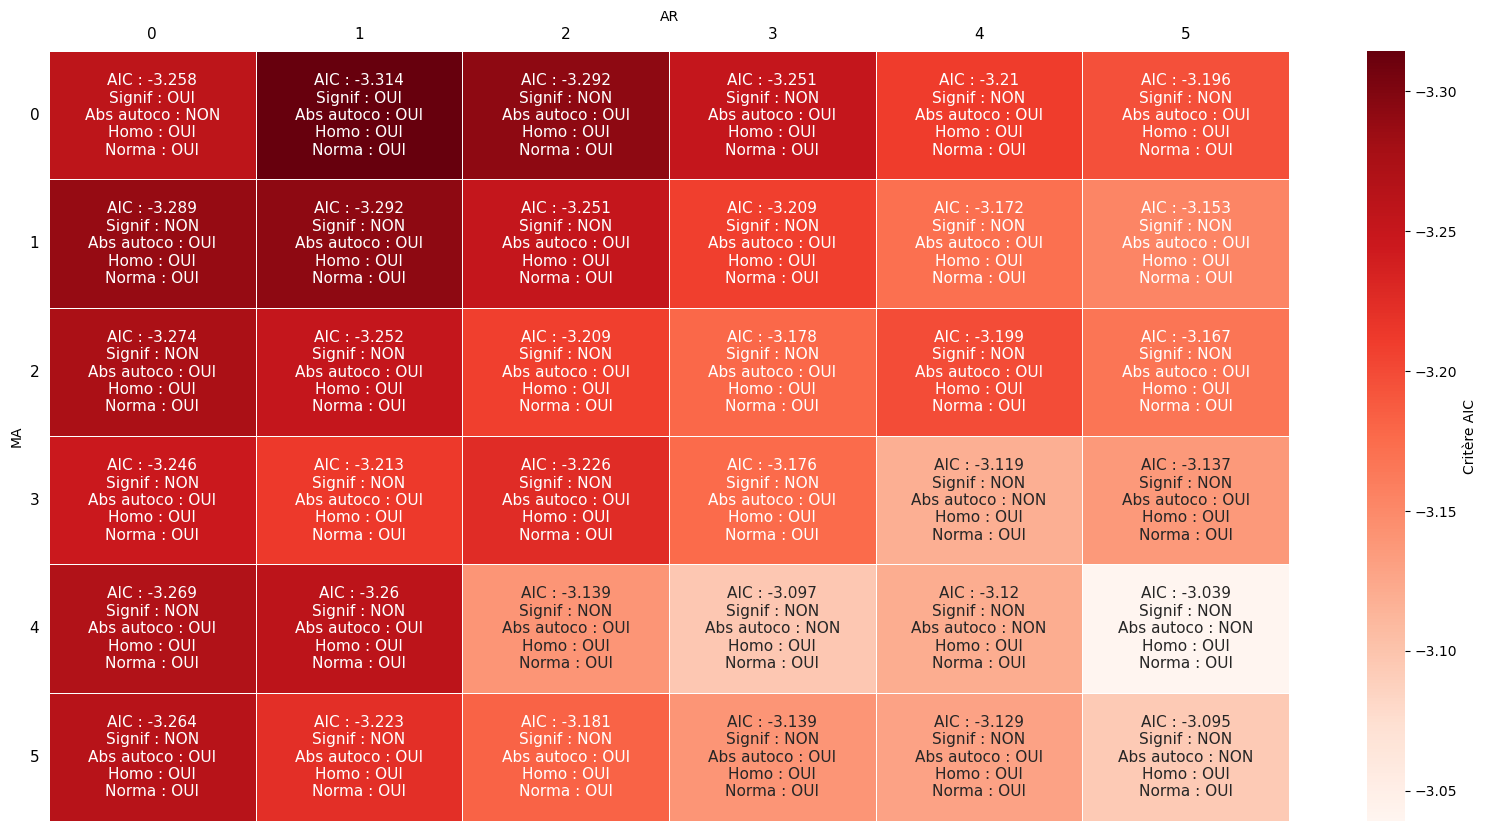

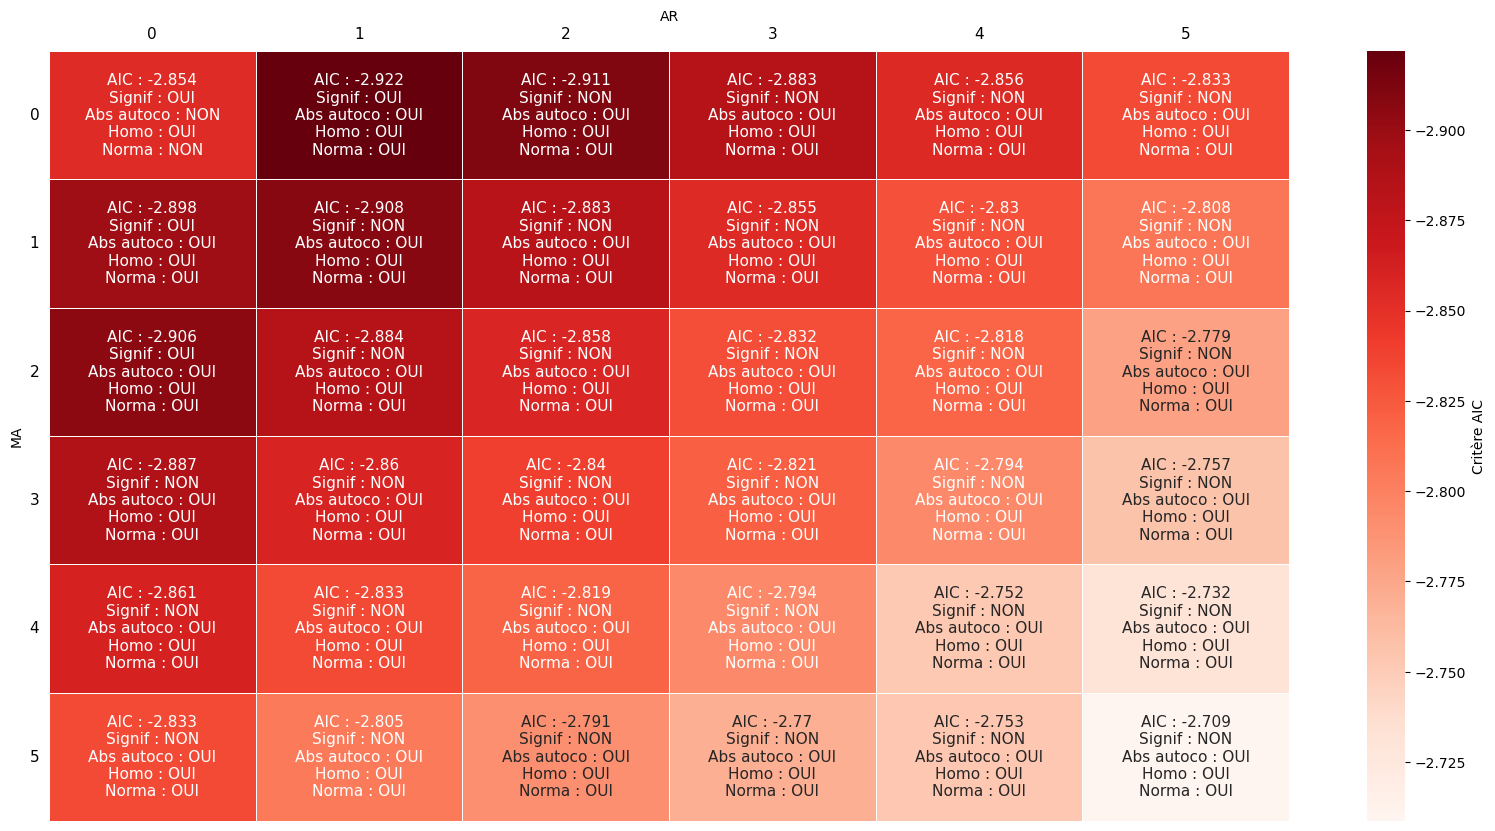

In [13]:

def heatmap_plot(df,name):
    fig, ax = plt.subplots(figsize=(20,10))
    ax = sns.heatmap(df1, 
                    annot=df, fmt="",
                    linewidth=.5 , 
                    cmap='Reds_r',
                    cbar_kws={'label': 'Critère AIC'},
                    annot_kws={'fontsize': 11})
    ax.set(xlabel="AR", ylabel="MA",)
    ax.xaxis.set_label_position('top') 
    ax.tick_params(axis='both', which='major', labelsize=11, labelbottom = False, bottom=False, top = False, left=False, labeltop=True, rotation=0)
    ax.collections[0].colorbar.ax.invert_yaxis()
    plt.savefig('../rendu/annexe/arma'+name+'.pgf',  bbox_inches = 'tight')
    plt.show()


for i in range(2):
    df1,df2,df3,df4,df5 = arma(df_list[i],6)
    df = concat(df1,df2,df3,df4,df5)
    heatmap_plot(df, df_list[i].columns[0])